<a href="https://colab.research.google.com/github/Yousef-Taheri/Machine-Learning-for-Medicine/blob/master/Bayesian%20Networks%5CBayesian%20Networks%20for%20Clinical%20Data%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Networks for Clinical Data Analysis
>The goal of the TME is to get skills in using the 
[PyAgrum library](http://agrum.gitlab.io/pages/pyagrum.html)
 and to learn how to construct Bayesian networks and dynamic Bayesian networks.

##**Data** 

>**•**Prediction of Type 2 Diabetes Remission:  dynamic data
><br>**•**Host and Environmental Data of Obese Patients

In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/ML_Medical/TP7'
os.chdir(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#  !pip install pyAgrum
import pandas as pd
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn

##Analysis

### Creating a network using PyAgrum.
>We  would  like  to  model  the  problem  of  type  2 diabetes remission after a gastric by-pass surgery which can be represented by the following graph (note, that the problem is simplified extremely!):

Create an empty BN network and add nodes

In [0]:
bn=gum.BayesNet('Diabetes')
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0}


In [0]:
nodes=[('g','Glycemia>6.5?',2),
       ('i','Insulin taken?',2),
       ('o','Other drugs taken?',2),
       ('r','Remission',2)]
g,i, o, r = [ bn.add(gum.LabelizedVariable(k[0], k[1], k[2])) for k in nodes ]

print (g,i,o,r)
print (bn)

0 1 2 3
BN{nodes: 4, arcs: 0, domainSize: 16, dim: 8}


Create the arcs and the probability tables

In [0]:
for link in [(g,i),(g,o),(i,r),(o,r)]:
    bn.addArc(*link)
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


In [0]:
bn.cpt(g).fillWith([0.5,0.5])

In [0]:
bn.cpt(o)[{'g': 1}] = [.25,.75]
bn.cpt(o)[{'g': 0}] = [.7,.3]

bn.cpt(i)[{'g': 1}] = [.1,.9]
bn.cpt(i)[{'g': 0}] = [.9,.1]

In [0]:
bn.cpt(r)[{'i': 1, 'o': 1}] = [.9,.1]
bn.cpt(r)[{'i': 0, 'o': 1}] = [.6,.4]
bn.cpt(r)[{'i': 1, 'o': 0}] = [.3,.7]
bn.cpt(r)[{'i': 0, 'o': 0}] = [.1,.9]

Visualize the graph

In [0]:
import pyAgrum.lib.notebook as gnb
bn

(gum::BayesNet<double>@0x3bffe00) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}

Perform inference (withLazyPropagation())

In [0]:
ie=gum.LazyPropagation(bn)

In [0]:
ie.makeInference()
ie.posterior(r)

(gum::Potential<double>@0x4941fe0) <r:0> :: 0.75 /<r:1> :: 0.25

Perform  inference  with  evidence.   What  is  the  probability  to  get  the  remission  if  the glycemia level is less than 6.5 and no drugs are taken?

In [0]:
ie.setEvidence({'g':0, 'o': 0})
ie.makeInference()
ie.posterior(r)

(gum::Potential<double>@0x4de1580) <r:0> :: 0.12 /<r:1> :: 0.88

What is the probability to get the remission if the glycemia level is bigger than 6.5 andinsulin is prescribed?

In [0]:
ie.setEvidence({'g':1, 'i': 1})
ie.makeInference()
ie.posterior(r)

(gum::Potential<double>@0x52a98e0) <r:0> :: 0.75 /<r:1> :: 0.25

### Construct Bayesian networks from real data.
>The data are inSPLEXenv.txt and SPLEXhost.txt files. Construct one network for the environmental variables, one for thehost variables, and one with both environmental and host data.

Load and discretize the data (the Bayesian networks are learned from discrete data only)To discretize the data, each column into 5 bins

In [0]:
SPLEXhost = pd.read_table('SPLEX_host.txt',sep=' ')
SPLEXenv = pd.read_table('SPLEX_env.txt',sep=' ')

In [0]:
concatenated_data=pd.concat([SPLEXhost,SPLEXenv],axis=1)

In [0]:
def discr_save(data,save_file_name):
  l=[]
  for col in data.columns.values:
    bins = np.linspace(min(data[col]), max(data[col]), 5)
    l.append(pd.DataFrame(np.digitize(data[col], bins),columns=[col]))
  discr_data=pd.concat(l, join='outer', axis=1)
  discr_data.to_csv(save_file_name+".csv",index=False)


In [0]:
discr_save(SPLEXhost,'discr_SPLEXhost')
discr_save(SPLEXenv,'discr_SPLEXenv')
discr_save(concatenated_data,'discr_concatenated_data')

Run a learner to learn a networks (test useLocalSearchWithTabuList() and useGreedyHillClimbing() functions)

In [0]:
def BNlearnWrapp(filePath,method):
  learner=gum.BNLearner(filePath)
  if method=='LocalSearch':
    learner.useLocalSearchWithTabuList()
  else:
    learner.useGreedyHillClimbing()
  return learner.learnBN()


In [0]:
import pyAgrum.lib.notebook as gnb
bn_SPLEXhost_localSearch=BNlearnWrapp("discr_SPLEXhost.csv",'LocalSearch')
bn_SPLEXhost_localSearch

(gum::BayesNet<double>@0x52c5600) BN{nodes: 45, arcs: 27, domainSize: 10^30.5712, dim: 1613}

In [0]:
bn_SPLEXhost_HillClimb=BNlearnWrapp("discr_SPLEXhost.csv",'HillClimb')
bn_SPLEXhost_HillClimb

(gum::BayesNet<double>@0x52c5000) BN{nodes: 45, arcs: 24, domainSize: 10^30.5712, dim: 1253}

In [0]:
bn_SPLEXenv_LocalSearch=BNlearnWrapp("discr_SPLEXenv.csv",'LocalSearch')
bn_SPLEXenv_LocalSearch

(gum::BayesNet<double>@0x52c4a00) BN{nodes: 63, arcs: 12, domainSize: 10^43.1935, dim: 773}

In [0]:
bn_SPLEXenv_HillClimb=BNlearnWrapp("discr_SPLEXenv.csv",'HillClimb')
bn_SPLEXenv_HillClimb

(gum::BayesNet<double>@0x52c3800) BN{nodes: 63, arcs: 12, domainSize: 10^43.1935, dim: 771}

In [0]:
bn_concatenated_data_LocalSearch=BNlearnWrapp("discr_concatenated_data.csv",'LocalSearch')
bn_concatenated_data_LocalSearch

(gum::BayesNet<double>@0x52c2c00) BN{nodes: 108, arcs: 43, domainSize: 10^73.7646, dim: 2157}

In [0]:
bn_concatenated_data_HillClimb=BNlearnWrapp("discr_concatenated_data.csv",'HillClimb')
bn_concatenated_data_HillClimb

(gum::BayesNet<double>@0x52c2600) BN{nodes: 108, arcs: 41, domainSize: 10^73.7646, dim: 2070}

Save the obtained networks

In [0]:
#dotize(bn, filename, format='pdf')
gum.saveBN(bn_SPLEXhost_localSearch,'bn_SPLEXhost_localSearch.bif')
gum.saveBN(bn_SPLEXhost_HillClimb,'bn_SPLEXhost_HillClimb.bif')
gum.saveBN(bn_SPLEXenv_LocalSearch,'bn_SPLEXenv_LocalSearch.bif')
gum.saveBN(bn_SPLEXenv_HillClimb,'bn_SPLEXenv_HillClimb.bif')
gum.saveBN(bn_concatenated_data_LocalSearch,'bn_concatenated_data_LocalSearch.bif')
gum.saveBN(bn_concatenated_data_HillClimb,'bn_concatenated_data_HillClimb.bif')

Are the networks learned with useLocalSearchWithTabuList()and useGreedyHillClimbing() similar?

No!

### Dynamic Bayesian networks
>Load data fromdynamic.txt. In this file, you have HbA1C (glycated hemoglobin), Gly (glycemia), Poids (weight of patients), and Status (remission, non-remission, or partial remission) for time 0, 1 and 5 years after the surgery. Construct a dynamic network to explore temporal dependencies in the data.


In [0]:
dynamic_data = pd.read_table('dynamic.txt',sep=' ')

In [0]:
discr_save(dynamic_data,'dynamic_discr')

The first step is to learn a Bayesian network bn_dynamic as in the previous task

In [0]:
learner=gum.BNLearner("dynamic_discr.csv")
learner.useLocalSearchWithTabuList()
bn_dynamic=learner.learnBN()
bn_dynamic

(gum::BayesNet<double>@0x599b800) BN{nodes: 12, arcs: 10, domainSize: 10^7.14806, dim: 199}

Visualize the network with time slices

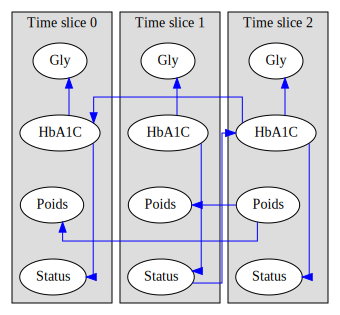

In [0]:
gdyn.showTimeSlices(bn_dynamic)